<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Introduction to the DP0.3 Moving Object Catalogs</b> <br>
Contact author: Bob Abel and Douglas Tucker<br>
Last verified to run: 2023-07-09 <br>
LSST Science Piplines version: Weekly 2023_21 <br>
Container size: medium <br>
Targeted learning level: beginner <br>

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** DP0.3 moving object catalogs are examined.

**Skills:** Discover moving object catalogs and create plots for preliminary analysis. 

**LSST Data Products:** TAP dp03_catalogs.

**Packages:** lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, numpy, matplotlib

**Credit:**
Mario Jurić provided essential assistance in the initial stages of creating this notebook.  The notebook authors would also like to acknowledge help from Leanne Guy, Pedro Bernardinelli, Sarah Greenstreet, Megan Schwamb, Brian Rogers, Niall McElroy, and Jake Vanderplass, among others.

**Get Support:**
Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach the user about the basic constituents of the DP0.3 data set.  DP0.3 consists of both real and simulated solar system objects (asteroids, near-earth objects, Trojans, trans-Neptunian objects, and even a simulated spaceship... but no comets, major planets, or the Moon).  It is a hybrid catalog in which objects from the Minor Planet Center have replaced objects with similar properties from the original simulated data set.  

Due to time and effort constraints, only catalog data are available.  Also, since the DP0.2 footprint is far from the ecliptic plane, only a very small fraction of DP0.3 would appear within a DP0.2 visit.  

For the real objects in the DP0.3, one should consult the `MPCORB` provided instead of querying the actual the Minor Planet Center (see below).

For additional information, please consult 
<a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>.


### 1.1 Package Imports

Import general python packages and the Rubin TAP service utilities.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Rectangle
import pandas as pd

from lsst.rsp import get_tap_service, retrieve_query

### 1.2 Define Functions and Parameters

Here, we define a function, `estDistFromHandAlbedo`, which estimates the diameter (in km) of an solar system object based on its solar system absolute magnitude, `H`, and its geometric albedo, `a`.  It assumes a spherical body and is just a rough estimate.  We will use it later.

We obtained this function from https://cneos.jpl.nasa.gov/tools/ast_size_est.html, where the diameter is estimated using the equation `estDiam` = $10^{[3.1236 - 0.5log_{10}a - 0.2H]}$.

In [3]:
def estDiamFromHandAlbedo(H, a=0.15):
    import numpy as np
    estDiam = np.power(10., 3.1236 - 0.5*np.log10(a) - 0.2*H)
    return estDiam

## 2. Create the Rubin SSO TAP Service client

Get an instance of the SSO TAP service, and assert that it exists.

_Note that the DP0.3 TAP service for DP0.3 is "ssotap", **not** "tap" (which is used for DP0.2)._ 

In [4]:
service = get_tap_service("ssotap")
assert service is not None

### 2.1 What are the Moving Object Schemas?

Let's take a look at which schemas are available in DP0.3.

In [5]:
query = "SELECT * FROM tap_schema.schemas"
results = service.search(query)
print(type(results))

<class 'pyvo.dal.tap.TAPResults'>


In [6]:
results = service.search(query).to_table().to_pandas()
results

,description,schema_index,schema_name,utype
0,Data Preview 0.3 contains the catalog products...,0,dp03_catalogs,
1,A TAP-standard-mandated schema to describe tab...,100000,tap_schema,
2,UWS Metadata,120000,uws,


We see that there is a dp03_catalogs schema.  If there were more schemas in the DP0.3 database, we could use the following to find the dp03 schemas specifically:

In [7]:
schema_names = results['schema_name']
for name in schema_names:
    if name.find('dp03') > -1:
        dp03_schema_name = name
        break
print("DP0.3 schema is " + dp03_schema_name)

DP0.3 schema is dp03_catalogs


### 2.2 What are in the DP0.3 catalogs?

Let's take a quick look at the meta-information for the tables in the `dp03_catalogs` schema.  In the following sections, we will look closer at each of these tables in more detail.

In [8]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = '" \
        + dp03_schema_name + "' order by table_index ASC"
print(query)

results = service.search(query)
results = results.to_table()
results

SELECT * FROM tap_schema.tables WHERE tap_schema.tables.schema_name = 'dp03_catalogs' order by table_index ASC


description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
The orbit catalog produced by the Minor Planet Center. Ingested daily. O(10M) rows by survey end. The columns are described at https://minorplanetcenter.net//iau/info/MPOrbitFormat.html,dp03_catalogs,0,dp03_catalogs.MPCORB,table,
"LSST-computed per-object quantities. 1:1 relationship with MPCORB. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSObject,table,
"LSST-computed per-source quantities. 1:1 relationship with DIASource. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSSource,table,
Table to store 'difference image sources'; - sources detected at SNR >=5 on difference images.,dp03_catalogs,0,dp03_catalogs.DiaSource,table,


## 3. What's in the MPCORB catalog and how big is it?

Let's first take a look at the `MPCORB` table, which provides an version of the Minor Planet Center orbit catalog relevant for the epochs of the Rubin DP0.3 catalog.

In [9]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.MPCORB")
results.to_table().to_pandas()

,COUNT
0,14600302


There are 14.6M rows. Let's try to pull out a random 1%, which would be about 146,000 rows.  

For the moment, we can try to do this most simply by making use of a temporary trick associated with the current version of the prompt processing data products:  the fact that `ssObjectId` is a randomly assigned 64-bit long unsigned integer.  (Note:  since ADQL interprets a 64-bit long unsigned integer as a 63-bit _signed_ integer, these range from a very large negative integer value to a very large positive integer value.)  To grab a random sample we grab objects over a relatively small range of values of `ssObjectId`.  

In [10]:
results = service.search("""SELECT max(ssObjectId), min(ssObjectId)
                            FROM dp03_catalogs.MPCORB""")

min = int(results[0].get('min'))
max = int(results[0].get('max'))
print('Absolute min, max = ', min, max)
min = int(max - (0.01 * max))
print('1% min, max (from top) = ', min, max)

Absolute min, max =  -9223370383071521539 9223370875126069107
1% min, max (from top) =  9131137166374808576 9223370875126069107


Now, we will grab a random 1% of objects from the `MPCORB` table, making use of the range of `ssObjectId` values we have just found.  (Actually, we will grab a _maximum_ of 1% of objects from the MPCORB table, since the random numbers are not continuous.)

(_Note that you'll have some warnings from this next query that aren't your fault and will be corrected in the future._)

In [11]:
query = """SELECT *
           FROM dp03_catalogs.MPCORB
           WHERE ssObjectId
           BETWEEN 9131137166374808576 AND 9223370875126069107"""

df = service.search(query).to_table().to_pandas()
df

,arc,arcEnd,arcStart,computer,e,epoch,flags,fullDesignation,incl,lastIncludedObservation,...,nopp,peri,pertsLong,pertsShort,q,reference,rms,ssObjectId,tperi,uncertaintyParameter
0,NaN,,,,0.570970,54800.000000,0,2011 SR00004K,25.939150,NaN,...,0,350.606980,,,6.113300,,NaN,9185009465900868832,20859.963850,
1,NaN,,,,0.363600,54800.000000,0,2011 SR0000iQ,16.353220,NaN,...,0,147.316050,,,17.303450,,NaN,9136273658435248197,51070.857800,
2,NaN,,,,0.422040,54800.000000,0,2011 SR0000jR,16.453660,NaN,...,0,274.863090,,,6.479600,,NaN,9196671585077870249,28521.104640,
3,NaN,,,,0.639530,54800.000000,0,2011 SR0000sn,15.263050,NaN,...,0,226.268830,,,9.611210,,NaN,9165069355693008015,47926.391840,
4,NaN,,,,0.558600,54800.000000,0,2011 SR0000O9,2.014410,NaN,...,0,342.576070,,,6.387960,,NaN,9204187278771900476,54049.125620,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73195,NaN,,,,0.699330,73349.917495,0,2011 SI00029q,8.924373,NaN,...,0,155.486565,,,1.010904,,NaN,9202444422702896229,72771.929158,
73196,NaN,,,,0.241565,82907.000554,0,2011 SI0002l6,9.715864,NaN,...,0,17.733114,,,0.974737,,NaN,9177118190137388277,83012.719158,
73197,NaN,,,,0.563781,61365.350292,0,2011 SI0002qP,4.110239,NaN,...,0,152.428342,,,0.949081,,NaN,9220586587601309840,61834.429501,
73198,NaN,,,,0.686982,64269.689620,0,2011 SI0002uH,1.053755,NaN,...,0,324.365268,,,0.873964,,NaN,9143316944274961815,65005.664047,


73200 rows have been returned, but 73200 is not 1% of 14600302.  As noted above, this number is less than 1% of the full number of objects in this table, but it is a large enough number for our current purposes; so let's go with it.

Let's now look at the column information for the data frame we have just created:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73200 entries, 0 to 73199
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   arc                      0 non-null      float32
 1   arcEnd                   73200 non-null  object 
 2   arcStart                 73200 non-null  object 
 3   computer                 73200 non-null  object 
 4   e                        73200 non-null  float64
 5   epoch                    73200 non-null  float64
 6   flags                    73200 non-null  int32  
 7   fullDesignation          73200 non-null  object 
 8   incl                     73200 non-null  float64
 9   lastIncludedObservation  0 non-null      float32
 10  mpcDesignation           73200 non-null  object 
 11  mpcG                     73200 non-null  float32
 12  mpcH                     73200 non-null  float32
 13  mpcNumber                73200 non-null  int32  
 14  n                     

Here, we will run the pandas `describe` command, which will output some basic population distribution information for the numerical columns in this pandas data frame.

In [13]:
df.describe()

,arc,e,epoch,flags,incl,lastIncludedObservation,mpcG,mpcH,mpcNumber,n,nobs,node,nopp,peri,q,rms,ssObjectId,tperi
count,0.0,73200.000000,73200.000000,73200.0,73200.000000,0.0,73200.000000,73200.000000,73200.0,0.0,73200.0,73200.000000,73200.0,73200.000000,73200.000000,0.0,7.320000e+04,73200.000000
mean,NaN,0.172112,54802.108534,0.0,10.972451,NaN,0.150000,20.617786,0.0,NaN,0.0,173.932257,0.0,180.749984,2.440706,NaN,9.177220e+18,52907.162296
std,NaN,0.107583,604.817406,0.0,7.747464,NaN,0.000048,2.177866,0.0,NaN,0.0,104.124396,0.0,104.058435,2.278329,NaN,2.656485e+16,4542.661808
min,NaN,-0.002850,54090.500000,0.0,0.000990,NaN,0.150000,4.760000,0.0,NaN,0.0,0.011650,0.0,0.003060,0.011427,NaN,9.131138e+18,-63479.039930
25%,NaN,0.105540,54800.000000,0.0,5.476818,NaN,0.150000,19.610001,0.0,NaN,0.0,83.460283,0.0,90.570802,1.956770,NaN,9.154216e+18,52026.268292
50%,NaN,0.157545,54800.000000,0.0,9.825595,NaN,0.150000,20.900000,0.0,NaN,0.0,167.617815,0.0,181.006430,2.199545,NaN,9.177232e+18,53802.349055
75%,NaN,0.211480,54800.000000,0.0,14.184455,NaN,0.150000,22.040001,0.0,NaN,0.0,264.383730,0.0,271.618565,2.574720,NaN,9.200119e+18,54421.656843
max,NaN,0.999930,90936.183867,0.0,154.846880,NaN,0.150000,26.540001,0.0,NaN,0.0,359.992530,0.0,359.994620,45.345770,NaN,9.223371e+18,112667.605180


There are several columns that only contain 'NaN' values.  Let's drop these columns:

In [14]:
df.dropna(axis=1, how='all', inplace=True)

Let's also drop any columns that contain only one distinct value (e.g., all columns are ' ' or all columns are 0).  We note that `mpcG` is one of the columns that will be dropped, since it was set to 0.15 for all the rows.

In [15]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)

Let's see what columns remain.

In [16]:
df.columns

Index(['e', 'epoch', 'fullDesignation', 'incl', 'mpcDesignation', 'mpcH',
       'node', 'peri', 'q', 'ssObjectId', 'tperi'],
      dtype='object')

Let's make some histograms for some of the remaining numerical columns.

Text(0.5, 0.98, 'Some MPCORB Histograms')

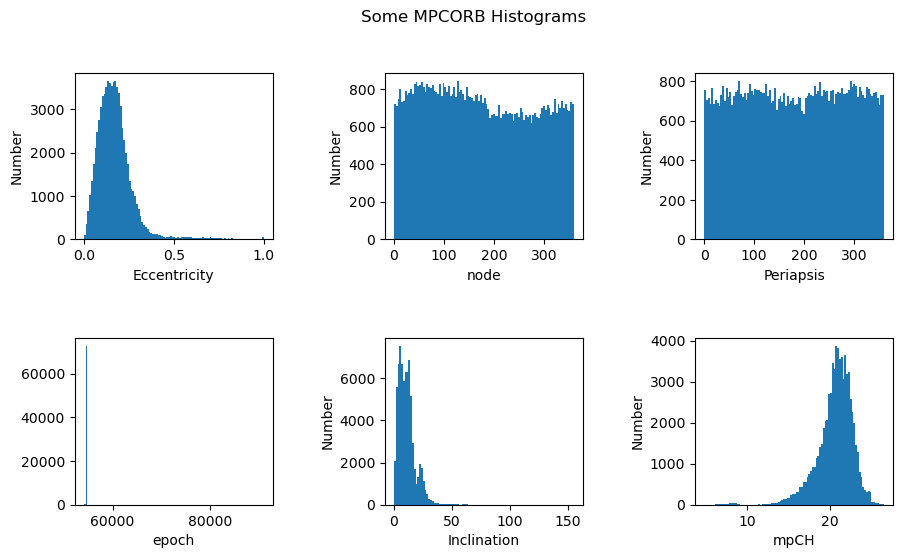

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout(pad=5.0)
ax[0, 0].hist(df['e'], bins=100)
ax[0, 0].set_xlabel('Eccentricity')
ax[0, 0].set_ylabel('Number')
ax[0, 1].hist(df['node'], bins=100)
ax[0, 1].set_xlabel('node')
ax[0, 1].set_ylabel('Number')
ax[0, 2].hist(df['peri'], bins=100)
ax[0, 2].set_xlabel('Periapsis')
ax[0, 2].set_ylabel('Number')
ax[1, 0].hist(df['epoch'], bins=100)
ax[1, 0].set_xlabel('epoch')
ax[1, 1].hist(df['incl'], bins=100)
ax[1, 1].set_xlabel('Inclination')
ax[1, 1].set_ylabel('Number')
ax[1, 2].hist(df['mpcH'], bins=100)
ax[1, 2].set_xlabel('mpCH')
ax[1, 2].set_ylabel('Number')
fig.suptitle('Some MPCORB Histograms')

Now let's estimate the diameters of these solar system objects.  We can do this by making use of the solar system absolute magnitudes, or `H` magnitudes, for these objects, by making a reasonable assumption for their geometric albedos, `a`, and by employing the function `estDiamFromHandAlbedo` we defined in Section 1.2 above.  The estimated diameters are in kilometers.

The `MPCORB` table does not include estimated geometric albedos; so we will make the and we will assume an albedo of `a`=0.15, which is not atypical for, say, an S-class asteroid.  Based on the table provided at https://cneos.jpl.nasa.gov/tools/ast_size_est.html, this does not appear to be a particularly bad assumption, and it appears unlikely that the diameter estimate for any particular object would be much more than a factor or 2-3 off (and, on average, much closer to the truth).

(_Recall that, for solar system objects, absolute magnitudes are defined to be for an object 1 A.U. from the Sun and 1 A.U. from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees._)

In [18]:
df['estDiam'] = estDiamFromHandAlbedo(df['mpcH'])

And let's look at the overall distribution of estimated diameters.

In [19]:
df['estDiam'].describe()

count    73200.000000
mean         0.863328
std          7.144678
min          0.016887
25%          0.134139
50%          0.226754
75%          0.410728
max        383.313629
Name: estDiam, dtype: float64

And plot the whole histogram:

Text(0.5, 1.0, 'Histogram of Estimated Asteroid Diameters')

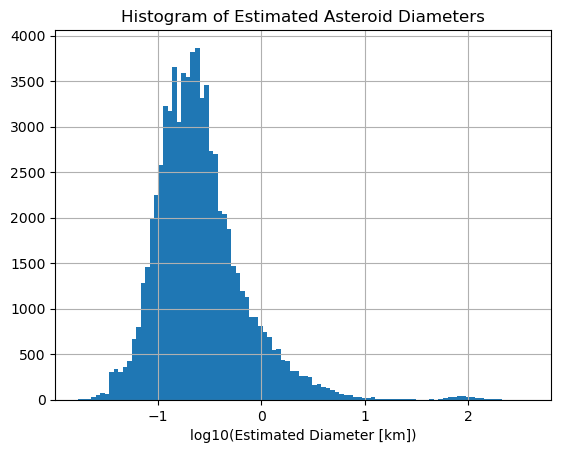

In [20]:
plt.hist(np.log10(df['estDiam']), bins=100)
plt.xlabel('log10(Estimated Diameter [km])')
plt.grid(True)
plt.title('Histogram of Estimated Asteroid Diameters')

Note the peak in the distribution is in the 0.1-0.3 km range, but that there is a much smaller, secondary peak near 100 km.

Now, before moving on, let us plot the sine of the inclination (sin(i)) and the eccentricity of the objects as a function of their semi-major axis.  We note that the sin(i) plot compares well with [Figure 5.5 in the LSST Science Book](https://www.lsst.org/sites/default/files/docs/sciencebook/SB_5.pdf).

Text(0.5, 1.0, 'Asteroid Semi-Major Axis vs. Eccentricity')

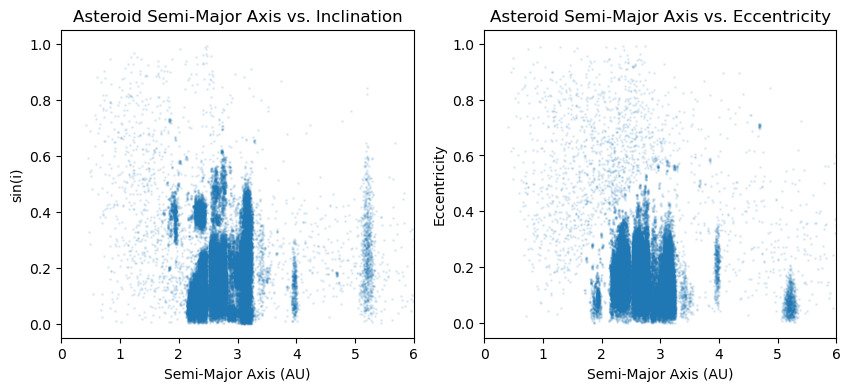

In [21]:
df['semi'] = df['q']/(1. - df['e'])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(df['semi'], np.sin(np.pi / 180. * df['incl']), alpha=0.1, s=1)
ax[0].set_xlim(0, 6)
ax[0].set_xlabel('Semi-Major Axis (AU)')
ax[0].set_ylabel('sin(i)')
ax[0].set_title('Asteroid Semi-Major Axis vs. Inclination')

ax[1].scatter(df['semi'], df['e'], alpha=0.1, s=1)
ax[1].set_xlim(0, 6)
ax[1].set_xlabel('Semi-Major Axis (AU)')
ax[1].set_ylabel('Eccentricity')
ax[1].set_title('Asteroid Semi-Major Axis vs. Eccentricity')


## 4. What's in the SSObject catalog and how big is it?

Now let's look at the `SSObject` table.  The `SSObject` table contains the Rubin-estimated properties of each solar system object detected by the Rubin data processing pipeline.

In [22]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSObject")
results.to_table().to_pandas()

,COUNT
0,10222593


Note that there are 10.2 million solar system objects detected by Rubin.  This is less than the 14.6 million objects in the `MPCORB` catalog.  It is left as an exercise for the student to determine the characteristics of those objects from the `MPCORB` table are missing from the `SSObject` table.

We also note that there are no artifacts added to the DP0.3 data set.

Below, as with the `MPCORB` table before, we will consider a random subset of objects based on their `ssObjectId` values.

In [23]:
query = """SELECT *
           FROM dp03_catalogs.ssObject
           WHERE ssObjectId
           BETWEEN 9131137166374808576 AND 9223370875126069107"""

df = service.search(query).to_table().to_pandas()
df

,arc,discoverySubmissionDate,firstObservationDate,flags,gChi2,gG12,gG12Err,gH,gH_gG12_Cov,gHErr,...,yH_yG12_Cov,yHErr,yNdata,zChi2,zG12,zG12Err,zH,zH_zG12_Cov,zHErr,zNdata
0,3089.883301,60599.295358,60592.295358,0,1.577042,0.338602,0.202955,21.161713,0.019386,0.106775,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,15.927057,61750.270241,61743.270241,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2.961222,62806.302010,62799.302010,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.000000,61654.218500,61647.218500,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3270.825439,60509.383445,60502.383445,0,1.676326,0.051856,0.138421,18.936575,0.018925,0.141764,...,NaN,NaN,0,1.403565,0.171461,0.162144,18.205658,0.016147,0.108125,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51223,3371.791992,60231.321519,60224.321519,0,4.592573,-0.060991,0.727745,20.432423,0.524340,0.738144,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51224,7.022134,60968.147893,60961.147893,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51225,3071.890625,60495.238170,60488.238170,0,1.098199,0.014991,0.073796,20.547508,0.004406,0.065489,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
51226,2400.992676,60533.149470,60526.149470,0,1.070196,0.354199,0.155204,20.241318,0.018267,0.120746,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0


There are 551228 rows.

Let us first look at the column information in this table.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51228 entries, 0 to 51227
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   arc                      51228 non-null  float32
 1   discoverySubmissionDate  51228 non-null  float64
 2   firstObservationDate     51228 non-null  float64
 3   flags                    51228 non-null  int64  
 4   gChi2                    23898 non-null  float32
 5   gG12                     23898 non-null  float32
 6   gG12Err                  23898 non-null  float32
 7   gH                       23898 non-null  float32
 8   gH_gG12_Cov              23898 non-null  float32
 9   gHErr                    23898 non-null  float32
 10  gNdata                   51228 non-null  int32  
 11  iChi2                    25998 non-null  float32
 12  iG12                     25998 non-null  float32
 13  iG12Err                  25998 non-null  float32
 14  iH                    

And let us output some basic population distribution information for the numerical columns in this pandas data frame.

In [25]:
df.describe()

,arc,discoverySubmissionDate,firstObservationDate,flags,gChi2,gG12,gG12Err,gH,gH_gG12_Cov,gHErr,...,yH_yG12_Cov,yHErr,yNdata,zChi2,zG12,zG12Err,zH,zH_zG12_Cov,zHErr,zNdata
count,51228.000000,51228.000000,51228.000000,51228.0,23898.000000,23898.000000,23898.000000,23898.000000,2.389800e+04,23898.000000,...,9.554000e+03,9554.000000,51228.000000,16529.000000,16529.000000,16529.000000,16529.000000,1.652900e+04,16529.000000,51228.000000
mean,2237.242676,60877.926892,60870.926892,0.0,1.586080,0.207300,0.148309,19.201159,4.723215e-01,0.067653,...,7.293496e-01,0.079366,8.029906,1.399849,0.242207,0.185852,17.937695,6.459200e-01,0.074233,14.292496
std,1294.842407,811.068102,811.068102,0.0,19.190218,0.537381,4.926117,1.631289,5.825462e+01,0.141413,...,3.454025e+01,0.216811,23.059113,21.845818,0.545157,4.346987,1.590755,4.571084e+01,0.190788,28.426004
min,0.000000,60225.001806,60218.001806,0.0,0.008994,-0.363811,0.000689,7.852705,4.783068e-07,0.000743,...,3.732586e-07,0.000598,0.000000,0.010297,-0.370921,0.000860,7.064597,7.848149e-07,0.000915,0.000000
25%,1443.909698,60335.153720,60328.153720,0.0,0.822909,0.132503,0.020725,18.288822,2.988165e-04,0.015811,...,3.231248e-04,0.017281,0.000000,0.876338,0.138876,0.018814,17.010714,2.625617e-04,0.015322,0.000000
50%,2815.402588,60532.265721,60525.265721,0.0,1.059144,0.161183,0.053647,19.437029,1.963094e-03,0.039965,...,2.098327e-03,0.041917,0.000000,1.056245,0.166425,0.051439,18.123823,1.899837e-03,0.039974,0.000000
75%,3276.731323,61134.598253,61127.598253,0.0,1.358298,0.214254,0.115312,20.333897,8.869050e-03,0.082781,...,1.058173e-02,0.089246,0.000000,1.278377,0.237976,0.122705,19.034119,9.744429e-03,0.086496,15.000000
max,3595.051025,63819.375091,63812.375091,0.0,2641.300293,65.545464,743.270447,25.592363,8.967290e+03,12.064754,...,3.024482e+03,9.891932,749.000000,2797.307861,41.361580,422.916138,24.245218,4.559956e+03,11.004877,544.000000


As we did with the `MSCORB` data set, let's drop rows that contain any `NaN`'s.

In [26]:
print('Number of rows before dropping all rows with NaNs: %d' % len(df))
df.dropna(inplace=True)
df.reset_index(inplace=True)
print('Number of rows after dropping all rows with NaNs: %d' % len(df))


Number of rows before dropping all rows with NaNs: 51228
Number of rows after dropping all rows with NaNs: 4774


Now let us calculate the Rubin colors for the SSObjects.  We will use the Rubin absolute ("H") magnitudes in the various Rubin filter bands to calculate the colors.  (Recall, for solar system objects, absolute magnitudes are defined to be for an object 1 A.U. from the Sun and 1 A.U. from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.)

In [27]:
df['ug'] = df['uH'] - df['gH']
df['gr'] = df['gH'] - df['rH']
df['ri'] = df['rH'] - df['iH']
df['iz'] = df['iH'] - df['zH']
df['zy'] = df['zH'] - df['yH']

Let's plot some color-color diagrams for these objects.

Text(0.5, 0.98, 'Color-Color Plots for SSObject Catalog')

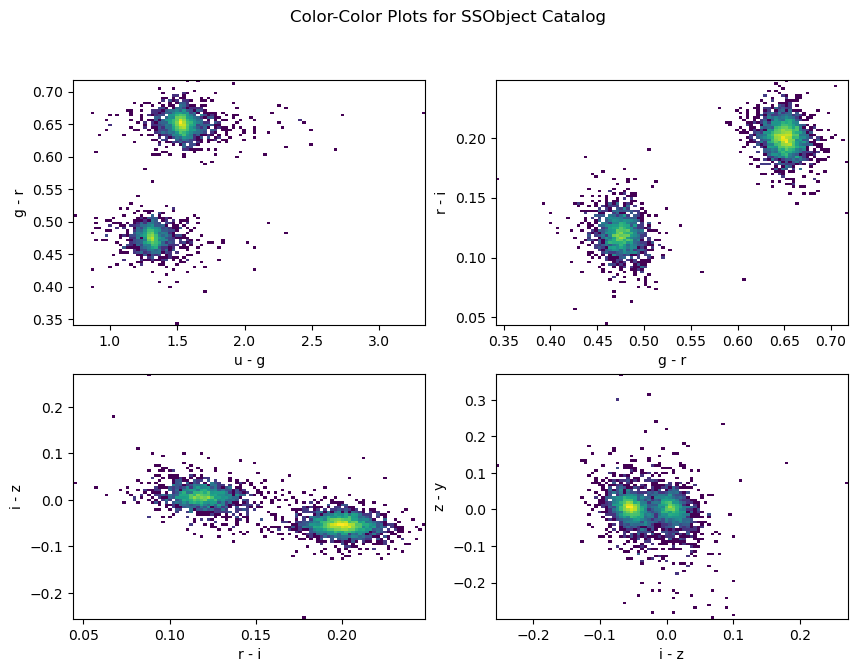

In [28]:
colors = ['ug', 'gr', 'ri', 'iz', 'zy']
filters = ['u', 'g', 'r', 'i', 'z', 'i']
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
m = 0
ax[0, 0].hist2d(df['ug'], df['gr'], bins=100, norm='log')
ax[0, 0].set_xlabel('u - g')
ax[0, 0].set_ylabel('g - r')
ax[0, 1].hist2d(df['gr'], df['ri'], bins=100, norm='log')
ax[0, 1].set_xlabel('g - r')
ax[0, 1].set_ylabel('r - i')
ax[1, 0].hist2d(df['ri'], df['iz'], bins=100, norm='log')
ax[1, 0].set_xlabel('r - i')
ax[1, 0].set_ylabel('i - z')
ax[1, 1].hist2d(df['iz'], df['zy'], bins=100, norm='log')
ax[1, 1].set_xlabel('i - z')
ax[1, 1].set_ylabel('z - y')
fig.suptitle('Color-Color Plots for SSObject Catalog')


There are only two populations of colors in the simulation; this will obviously change when we look at the real Solar System with real (non-simulated) Rubin data in the future. 

## 5. What's in the SSSource catalog and how big is it?

Now let's look at the `SSSource` table.

In [29]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


**_This table contains over a billion sources!_**

As before, we will consider a random set of objects based on their `ssObjectId` values.
Due to the large size of this table, we'll pull a much smaller data set.


In [30]:
minSSSource = int(max - (0.001 * max))
print(minSSSource)

9214147504250943488


In [31]:
query = """SELECT *
           FROM dp03_catalogs.SSSource
           WHERE ssObjectId
           BETWEEN 9214147504250943488 AND 9223370875126069107"""

df = service.search(query).to_table().to_pandas()
df

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,...,residualDec,residualRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ
0,-2331882174261098207,-11.977874,214.414018,36.672334,319.926573,2.250939,0.002137,-0.010669,-0.005300,-2.165653,...,NaN,NaN,9214148730396380762,2.381151,0.019189,-0.006483,-0.003577,-1.921621,-1.011252,-0.977048
1,867347560563835451,-15.119655,228.103572,25.463550,329.097010,2.255840,0.004214,-0.010336,-0.004617,-2.044600,...,NaN,NaN,9214148730396380762,1.948943,0.014820,0.002563,0.000875,-1.256424,-1.082706,-1.023486
2,4057711316122120355,-17.492563,233.362051,20.162046,330.974123,2.263776,0.005438,-0.009930,-0.004100,-1.928697,...,NaN,NaN,9214148730396380762,1.688748,0.009464,0.005736,0.002600,-0.961168,-0.983861,-0.979817
3,-4559935229320354350,-17.495300,233.365569,20.157722,330.974360,2.263787,0.005439,-0.009930,-0.004099,-1.928556,...,NaN,NaN,9214148730396380762,1.688483,0.009424,0.005720,0.002601,-0.960923,-0.983713,-0.979750
4,-9077906755528548216,-18.699501,234.546349,18.517926,330.821463,2.269094,0.006015,-0.009674,-0.003821,-1.860042,...,NaN,NaN,9214148730396380762,1.573394,0.006459,0.006365,0.003044,-0.864463,-0.913176,-0.945717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514641,-8857431520458120138,-15.239537,301.442841,-34.547427,7.913147,1.565803,0.014085,0.006549,0.001958,0.676967,...,NaN,NaN,9223370875126069107,0.566274,-0.001640,0.000321,-0.000657,0.285008,-0.368461,-0.321983
514642,-4238294346999639404,-15.241860,301.439287,-34.545363,7.908787,1.565805,0.014084,0.006551,0.001959,0.677313,...,NaN,NaN,9223370875126069107,0.566258,-0.001607,0.000300,-0.000659,0.284968,-0.368454,-0.321999
514643,-8042164758176009436,-15.239490,301.442907,-34.547464,7.913231,1.565803,0.014085,0.006549,0.001958,0.676961,...,NaN,NaN,9223370875126069107,0.566274,-0.001640,0.000322,-0.000657,0.285009,-0.368462,-0.321983
514644,-9191273500434976743,-15.241812,301.439359,-34.545404,7.908877,1.565805,0.014084,0.006551,0.001959,0.677307,...,NaN,NaN,9223370875126069107,0.566259,-0.001607,0.000301,-0.000659,0.284969,-0.368454,-0.321999


As before, let us first look at the column information in this table.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514646 entries, 0 to 514645
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   diaSourceId              514646 non-null  int64  
 1   eclipticBeta             514646 non-null  float64
 2   eclipticLambda           514646 non-null  float64
 3   galacticB                514646 non-null  float64
 4   galacticL                514646 non-null  float64
 5   heliocentricDist         514646 non-null  float32
 6   heliocentricVX           514646 non-null  float32
 7   heliocentricVY           514646 non-null  float32
 8   heliocentricVZ           514646 non-null  float32
 9   heliocentricX            514646 non-null  float32
 10  heliocentricY            514646 non-null  float32
 11  heliocentricZ            514646 non-null  float32
 12  mpcUniqueId              514646 non-null  int64  
 13  phaseAngle               514646 non-null  float32
 14  pred

Also as before, let us output some basic population distribution information for the numerical columns in this pandas data frame.

In [33]:
df.describe()

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,...,residualDec,residualRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ
count,5.146460e+05,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,...,0.0,0.0,5.146460e+05,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000,514646.000000
mean,-6.021397e+15,-3.701349,208.295829,3.030198,181.261065,3.096588,0.002028,-0.000536,-0.000260,-0.366218,...,NaN,NaN,9.218747e+18,2.318339,0.000286,0.000642,0.000247,-0.298273,-0.356570,-0.291738
std,5.327416e+18,10.615647,95.572217,43.940689,122.585148,3.530630,0.006618,0.007269,0.003538,3.801753,...,NaN,NaN,2.631951e+15,3.548708,0.007399,0.006689,0.003156,3.466444,2.155892,1.003623
min,-9.223370e+18,-78.895823,0.000110,-89.355725,0.000281,0.744730,-0.018952,-0.017738,-0.012280,-40.017704,...,NaN,NaN,9.214149e+18,0.037801,-0.025535,-0.023141,-0.014014,-40.558441,-30.408916,-15.749660
25%,-4.616195e+18,-10.085491,151.349316,-38.151335,46.718966,2.370523,-0.003329,-0.007495,-0.003271,-2.232724,...,NaN,NaN,9.216452e+18,1.538941,-0.005578,-0.004748,-0.002017,-1.528456,-1.250779,-0.632712
50%,-1.159384e+16,-3.226892,212.892058,7.242059,205.264617,2.729401,0.002902,-0.001691,-0.000696,-0.587226,...,NaN,NaN,9.218757e+18,1.921298,-0.000211,0.001059,0.000380,-0.337169,-0.468842,-0.247692
75%,4.607870e+18,3.165038,288.085212,43.040543,294.927624,3.054721,0.007876,0.006801,0.002817,1.767063,...,NaN,NaN,9.221033e+18,2.309335,0.006214,0.005947,0.002517,1.092305,0.611108,0.084721
max,9.223332e+18,39.092158,359.999502,84.298126,359.999691,61.776371,0.020334,0.020581,0.014676,41.551609,...,NaN,NaN,9.223371e+18,62.031693,0.026307,0.024646,0.015050,42.272457,53.308113,24.618116


Now try looking at just one object. We will try `ssObjectId` 67935125885111706806793512588511170680.  We will plot its orbit in the XY plane, but we will try both heliocentric ("Sun-centered") and topocentric ("observatory-centered) coordinates.

First, we query for the heliocentric and topocentric X,Y coordinates for this asteroid.  The units for these coordinates are in A.U.

In [34]:
query = """SELECT heliocentricX, heliocentricY,
                  topocentricX, topocentricY, ssObjectId
           FROM dp03_catalogs.SSSource
           WHERE (ssObjectId = 6793512588511170680)"""

df_xy = service.search(query).to_table().to_pandas()
df_xy

,heliocentricX,heliocentricY,topocentricX,topocentricY,ssObjectId
0,-1.120697,-1.627495,-0.506155,-2.333641,6793512588511170680
1,-1.120668,-1.627519,-0.506084,-2.333634,6793512588511170680
2,-1.082890,-1.657938,-0.414987,-2.322733,6793512588511170680
3,-1.082860,-1.657961,-0.414918,-2.322722,6793512588511170680
4,-1.082831,-1.657984,-0.414848,-2.322711,6793512588511170680
...,...,...,...,...,...
482,-0.196160,1.952139,0.624825,1.448362,6793512588511170680
483,-1.003959,1.610761,-0.195555,2.160848,6793512588511170680
484,-1.003991,1.610739,-0.195618,2.160866,6793512588511170680
485,-1.004024,1.610717,-0.195680,2.160884,6793512588511170680


Note we have 487 observations for this object.

Now, let's create 2 plots side-by-side:  the orbit of this asteroid in heliocentric coordinates, and its orbit in topocentric coordinates.  Note how nice and smooth the orbit is in heliocentric coordinates, whereas, in topocentric coordinates, the Earth's orbit is imprinted on the orbit.  (For the topocentric coordinates, the Earth's rotation also contributes, but it is a much, much smaller effect on the scale of these plots.)

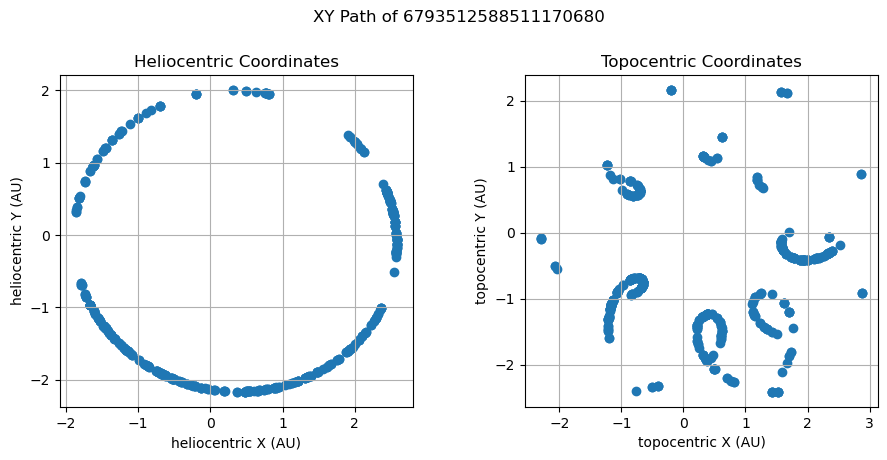

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
fig.suptitle('XY Path of 6793512588511170680')

ax[0].scatter(df_xy['heliocentricX'], df_xy['heliocentricY'])
ax[0].set_xlabel('heliocentric X (AU)')
ax[0].set_ylabel('heliocentric Y (AU)')
ax[0].set_title('Heliocentric Coordinates')
ax[0].grid()

ax[1].scatter(df_xy['topocentricX'], df_xy['topocentricY'])
ax[1].set_xlabel('topocentric X (AU)')
ax[1].set_ylabel('topocentric Y (AU)')
ax[1].set_title('Topocentric Coordinates')
ax[1].grid()

## 6. What's in the DiaSource catalog and how big is it?


Now let's look at the `DiaSource` table.

In [36]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.DiaSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


Same situation as SSSource - over a billion objects, so use the same limits as for SSSource.

In [37]:
query = """SELECT *
           FROM dp03_catalogs.DiaSource
           WHERE ssObjectId
           BETWEEN 9214147504250943488 AND 9223370875126069107"""

df = service.search(query).to_table().to_pandas()
df

,_decTrue,_magTrue,_name,_raTrue,_V,ccdVisitId,decl,declSigma,diaObjectId,diaSourceId,filter,mag,magSigma,midPointTai,ra,ra_decl_Cov,raSigma,snr,ssObjectId,ssObjectReassocTime
0,-24.225311,23.053452,S100sanTa,207.755563,23.308453,674480,-24.225271,0.000012,-9194409445772103316,-2331882174261098207,r,23.011091,0.105311,61410.336766,207.755559,0.0,0.000012,9.817913,9214148730396380762,61410.33676566108
1,-31.678294,23.319633,S100sanTa,220.752671,22.924633,698833,-31.678287,0.000004,-6256623948270999662,867347560563835451,g,23.202835,0.051420,61448.322456,220.752679,0.0,0.000004,20.618900,9214148730396380762,61448.32245558813
2,-35.464861,22.956850,S100sanTa,225.668462,22.561850,715404,-35.464856,0.000004,7731624285748347487,4057711316122120355,g,22.909597,0.043292,61472.302620,225.668472,0.0,0.000004,24.582699,9214148730396380762,61472.30261962077
3,-35.468458,22.306400,S100sanTa,225.671436,22.561399,715454,-35.468452,0.000004,-2233634430585881080,-4559935229320354350,r,22.361153,0.036251,61472.328547,225.671433,0.0,0.000004,29.453165,9214148730396380762,61472.32854716052
4,-36.946448,21.941467,S100sanTa,226.569719,22.347467,724652,-36.946441,0.000015,-2049956630163863401,-9077906755528548216,y,21.535053,0.155601,61484.286459,226.569734,0.0,0.000015,6.489630,9214148730396380762,61484.286458514434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514641,-34.652599,24.401119,S103XLFDa,307.722253,24.006119,1204168,-34.652585,0.000010,-1924715674319929053,-8857431520458120138,g,24.499786,0.128201,62332.289671,307.722266,0.0,0.000010,7.978828,9223370875126069107,62332.28967146229
514642,-34.655695,23.750782,S103XLFDa,307.718947,24.005781,1204218,-34.655698,0.000020,3318635922697265774,-4238294346999639404,r,23.661789,0.167787,62332.314235,307.718945,0.0,0.000020,5.983797,9223370875126069107,62332.314234522964
514643,-34.652541,24.401125,S103XLFDa,307.722315,24.006126,1204167,-34.652524,0.000010,-7997578408965141681,-8042164758176009436,g,24.408400,0.129775,62332.289214,307.722327,0.0,0.000010,7.876266,9223370875126069107,62332.28921414037
514644,-34.655637,23.750788,S103XLFDa,307.719008,24.005789,1204217,-34.655634,0.000021,2880493405153015000,-9191273500434976743,r,23.808342,0.170734,62332.313777,307.719012,0.0,0.000021,5.872323,9223370875126069107,62332.313777201045


As before, let us first look at the column information in this table.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514646 entries, 0 to 514645
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _decTrue             514646 non-null  float64
 1   _magTrue             514646 non-null  float32
 2   _name                514646 non-null  object 
 3   _raTrue              514646 non-null  float64
 4   _V                   514646 non-null  float32
 5   ccdVisitId           514646 non-null  int64  
 6   decl                 514646 non-null  float64
 7   declSigma            514646 non-null  float32
 8   diaObjectId          514646 non-null  int64  
 9   diaSourceId          514646 non-null  int64  
 10  filter               514646 non-null  object 
 11  mag                  514646 non-null  float32
 12  magSigma             514646 non-null  float32
 13  midPointTai          514646 non-null  float64
 14  ra                   514646 non-null  float64
 15  ra_decl_Cov      

Also as before, let us output some basic population distribution information for the numerical columns in this pandas data frame.

In [39]:
df.describe()

,_decTrue,_magTrue,_raTrue,_V,ccdVisitId,decl,declSigma,diaObjectId,diaSourceId,mag,magSigma,midPointTai,ra,ra_decl_Cov,raSigma,snr,ssObjectId
count,514646.000000,514646.000000,514646.000000,514646.000000,5.146460e+05,514646.000000,514646.000000,5.146460e+05,5.146460e+05,514646.000000,514646.000000,514646.000000,514646.000000,514646.0,514646.000000,514646.000000,5.146460e+05
mean,-8.362427,22.087847,205.737021,22.282639,1.032641e+06,-8.362427,0.000010,5.297778e+15,-6.021397e+15,22.055664,0.089893,62025.944386,205.737021,0.0,0.000010,44.149811,9.218747e+18
std,15.778468,1.483086,96.947107,1.453880,6.023367e+05,15.778468,0.000008,5.324704e+18,5.327416e+18,1.455657,0.065307,1062.851854,96.947107,0.0,0.000008,335.270630,2.631951e+15
min,-75.258849,9.429569,0.000227,9.878193,0.000000e+00,-75.258830,0.000002,-9.223371e+18,-9.223370e+18,9.429520,0.000040,60218.001806,0.000219,0.0,0.000002,2.000869,9.214149e+18
25%,-19.521627,21.286507,149.795458,21.507511,5.158402e+05,-19.521623,0.000004,-4.614686e+18,-4.616195e+18,21.279422,0.035079,61120.114747,149.795456,0.0,0.000004,7.596153,9.216452e+18
50%,-7.969309,22.307778,208.205063,22.519769,1.021876e+06,-7.969314,0.000008,1.314509e+16,-1.159384e+16,22.284940,0.079807,61977.018052,208.205074,0.0,0.000008,13.110600,9.218757e+18
75%,2.567805,23.157894,287.382044,23.347863,1.574760e+06,2.567809,0.000014,4.615755e+18,4.607870e+18,23.115697,0.134276,62971.266158,287.382031,0.0,0.000014,30.453516,9.221033e+18
max,36.040356,25.989101,359.999735,25.724369,2.049987e+06,36.040345,0.000192,9.223338e+18,9.223332e+18,25.234167,0.440071,63813.106689,359.999729,0.0,0.000192,27247.751953,9.223371e+18


It seems like the true values of RA, Dec and mag nearly agree with the observed values, but the observed values have some regular, Gaussian-like error distribution added.  Let's plot the offsets.

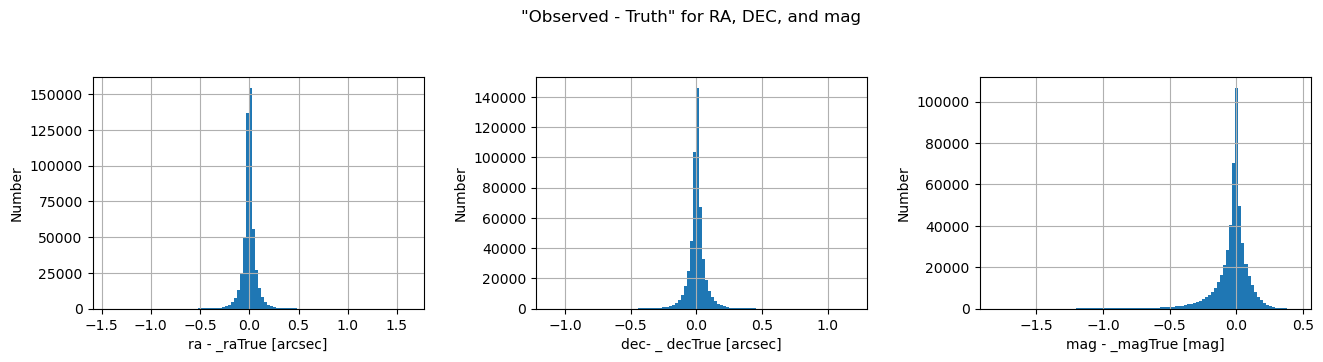

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig.tight_layout(pad=5.0)
fig.suptitle('"Observed - Truth" for RA, DEC, and mag')

ax[0].hist(3600.*(df['ra']-df['_raTrue']), bins=100)
ax[0].set_xlabel('ra - _raTrue [arcsec]')
ax[0].set_ylabel('Number')
ax[0].grid(True)

ax[1].hist(3600.*(df['decl']-df['_decTrue']), bins=100)
ax[1].set_xlabel('dec- _ decTrue [arcsec]')
ax[1].set_ylabel('Number')
ax[1].grid(True)

ax[2].hist(df['mag']-df['_magTrue'], bins=100)
ax[2].set_xlabel('mag - _magTrue [mag]')
ax[2].set_ylabel('Number')
ax[2].grid(True)

Now let us plot the asteroid distribution as a function of RA and DEC, adding a red rectangle that shows the rough location of the **DP0.2** data set.   Note that there is a small but non-negligible sky overlap with DP0.2. We leave it to the reader to see if the DP0.3 dates of observation also overlap with those from DP0.2.

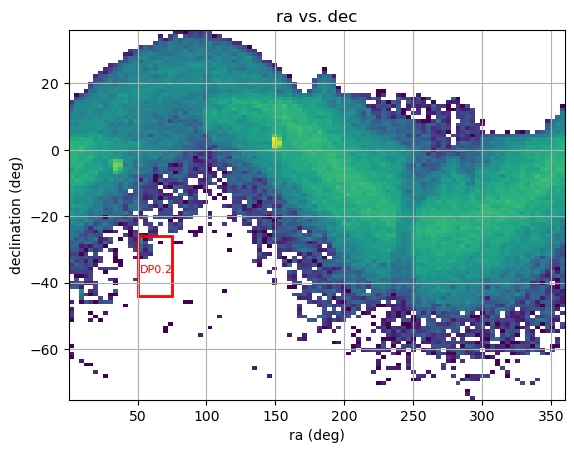

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist2d(df['ra'], df['decl'], bins=100, norm='log')
plt.xlabel('ra (deg)')
plt.ylabel('declination (deg)')
plt.title('ra vs. dec')
ax.add_patch(Rectangle((50, -44), 25, 18,
                       edgecolor='red',
                       fill=False,
                       lw=2))
ax.annotate(
    'DP0.2',
    xy=(52, -37), xycoords='data',
    xytext=(0, 0), textcoords='offset points',
    color='red', size=8.0)

ax.grid()

Recall this plot is derived from the `DiaSource` table, and the RA,DEC coordinates change over time for each DiaSource.  Thus, coherent features seen in the above plot are due to observing strategy and not to unchanging positions of the DiaSources themselves.  For  instance, the two dense (yellow-green) squares near RA,DEC=(40,-5) and (150,+2) are due to two Deep Drilling Fields in the DP0.3 data -- i.e., fields observed much more than other fields nearby.

Finally, let's take a look at the `DiaSource` data for the same object -- ssObjectId = 6793512588511170680 -- that we studied the orbit of in both heliocentric and topocentric coordinates in Section 5.

In [42]:
query = """SELECT ra, decl, mag, midPointTai, ssObjectId
           FROM dp03_catalogs.DiaSource
           WHERE (ssObjectId = 6793512588511170680)"""
df = service.search(query).to_table().to_pandas()
df

,ra,decl,mag,midPointTai,ssObjectId
0,257.762368,-21.632050,21.141586,60338.376183,6793512588511170680
1,257.764027,-21.632130,20.978247,60338.379279,6793512588511170680
2,259.870221,-21.685700,21.180084,60342.378116,6793512588511170680
3,259.871830,-21.685735,21.183739,60342.381213,6793512588511170680
4,259.873435,-21.685776,21.172150,60342.384312,6793512588511170680
...,...,...,...,...,...
482,66.664573,16.850791,20.200594,63643.073741,6793512588511170680
483,95.171149,19.616284,20.659369,63713.965215,6793512588511170680
484,95.172755,19.616278,20.765162,63713.968310,6793512588511170680
485,95.174330,19.616254,20.703131,63713.971404,6793512588511170680


Let' now plot this object's RA,DEC history, colored by each observation's midpoint TAI value (in days).

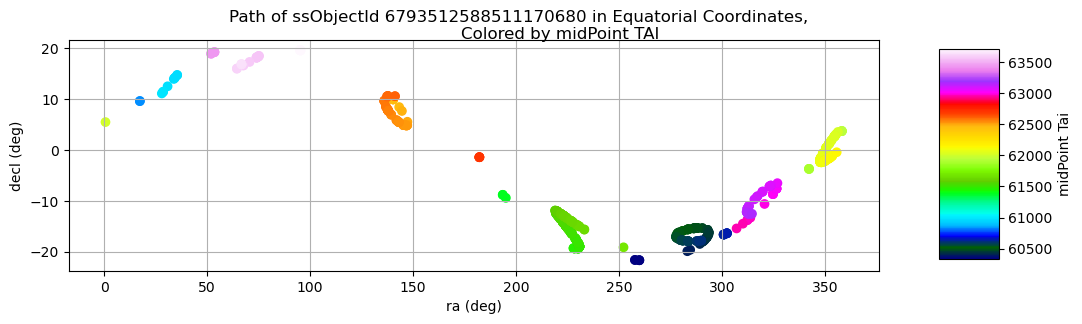

In [43]:
# These color-color plots markers are colored by TAI.

cmap = colormaps['gist_ncar']
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
im = ax.scatter(df['ra'], df['decl'], c=df['midPointTai'], cmap=cmap)
ax.set_xlabel('ra (deg)')
ax.set_ylabel('decl (deg)')

fig.suptitle("""Path of ssObjectId 6793512588511170680 in Equatorial Coordinates,
                Colored by midPoint TAI""")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='midPoint Tai')

ax.grid(True)


We can also plot this object's observed apparent magnitude vs. time (mid-point TAI, in days).  It appears to have a ~500 day periodicity, plus longer periods probably related to the fact that the the asteroid and our telescope are in different orbits.

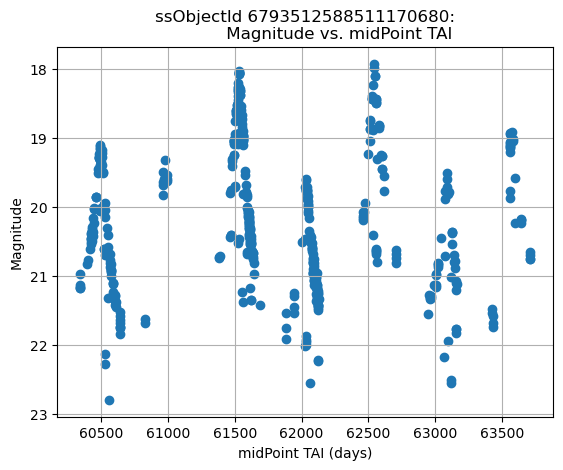

In [44]:
plt.scatter(df['midPointTai'], df['mag'])
plt.gca().invert_yaxis()
plt.xlabel('midPoint TAI (days)')
plt.ylabel('Magnitude')
plt.title("""ssObjectId 6793512588511170680:
             Magnitude vs. midPoint TAI""")
plt.grid(True)

## 7. Exercises for the reader


 **TBD**
